### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score,cross_val_predict
%matplotlib inline
plt.style.use('seaborn-pastel')

import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz2.38\bin'

In [2]:
data = pd.read_csv(r'events_log.csv')
data.timestamp = data.timestamp.apply(lambda x: datetime.datetime.utcfromtimestamp(int(x/1000)))

In [3]:
data['day'] = data.timestamp.apply(lambda x: pd.datetime.date(x).day)
data['month'] = data.timestamp.apply(lambda x: pd.datetime.date(x).month)

In [4]:
data.head(5)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day,month
0,00000736167c507e8ec225bd9e71f9e5,2608-11-08 19:38:23,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN,8,11
1,00000c69fe345268935463abbfa5d5b3,2608-11-08 21:16:45,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN,8,11
2,00003bfdab715ee59077a3670331b787,2608-11-08 19:55:45,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN,8,11
3,0000465cd7c35ad2bdeafec953e08c1a,2608-11-08 19:57:02,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0,8,11
4,000050cbb4ef5b42b16c4d2cf69e6358,2608-11-08 19:54:55,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN,8,11


In [5]:
data.nunique()

uuid               400165
timestamp            1131
session_id          68028
group                   2
action                  3
checkin                15
page_id            176371
n_results              92
result_position       193
day                     1
month                   1
dtype: int64

## What is their daily overall clickthrough rate? How does it vary between the groups?


This data contain only one day user activity. So, I guess I have to find for that day only. For Overall clickthrough rate I am sampling data where the search results have some count as if there are no search result than user have nothing to click on.

***Overall clickthrough rate:***

In [5]:
sessionids = data[(data.action == 'searchResultPage') & ((data.n_results > 0))].session_id.values
clickthroughdata = data[data.session_id.isin(sessionids)]

usercountwhoclicked = sum(clickthroughdata.groupby(['session_id'])['checkin'].count() > 0)
totalusers = len(clickthroughdata.groupby(['session_id'])['checkin'].count())

In [6]:
print("Overall clickthrough rate :", usercountwhoclicked/totalusers)

Overall clickthrough rate : 0.3870010832430631


***variation between groups:***

In [7]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

In [19]:
A_usercountwhoclicked = sum(A.groupby(['session_id'])['checkin'].count() > 0)
A_totalusers = len(A.groupby(['session_id'])['checkin'].count())

B_usercountwhoclicked = sum(B.groupby(['session_id'])['checkin'].count() > 0)
B_totalusers = len(B.groupby(['session_id'])['checkin'].count())

In [30]:
print("Clickthrough rate for group(a) user:", A_usercountwhoclicked/A_totalusers)

print("Clickthrough rate for group(b) user:", B_usercountwhoclicked/B_totalusers)

Clickthrough rate for group(a) user: 0.6249016663090896
Clickthrough rate for group(b) user: 0.17934392459190363


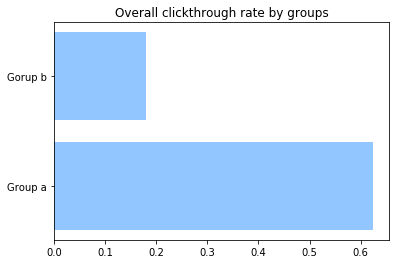

In [11]:
plt.barh(range(2),[.624,.179])
plt.yticks(range(2),['Group a','Gorup b'])
plt.title('Overall clickthrough rate by groups')
plt.show()

## Q.  Which result position do people tend to try first? How does it change day-to-day?


***Not able to find as there is ambiquity in timestamps***

## Q. What is their daily overall zero results rate? How does it vary between the groups?


In [21]:
Zeroresult = data[(data.action == 'searchResultPage') & (data.n_results == 0)]


In [22]:
print("zero results rate :", len(Zeroresult)/len(data[(data.action == 'searchResultPage')]))

zero results rate : 0.18444000763392399


***variation between groups:***

In [24]:
ZA = Zeroresult[Zeroresult.group == 'a']
ZB = Zeroresult[Zeroresult.group == 'b']

In [28]:
print("zero results rate for group(a) user:", len(ZA)/len(data[((data.action == 'searchResultPage') & (data.group == 'a'))]))

print("zero results rate for group(b) user:", len(ZB)/len(data[((data.action == 'searchResultPage') & (data.group == 'b'))]))

zero results rate for group(a) user: 0.1836056313548275
zero results rate for group(b) user: 0.1861786409525103


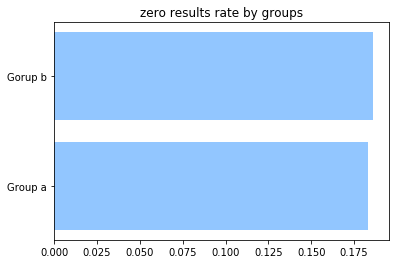

In [29]:
plt.barh(range(2),[.183,.186])
plt.yticks(range(2),['Group a','Gorup b'])
plt.title('zero results rate by groups')
plt.show()

## Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.


In [33]:
A = clickthroughdata[clickthroughdata.group == 'a']
B = clickthroughdata[clickthroughdata.group == 'b']

group_A = A.groupby(['session_id'])['timestamp']
group_B = B.groupby(['session_id'])['timestamp']

In [34]:
start_A = group_A.min() #minimum time for a session id would be the time for first event
end_A = group_A.max() #maximum time for a session id would be the time for last event

start_B = group_B.min() #minimum time for a session id would be the time for first event
end_B = group_B.max() #maximum time for a session id would be the time for last event


In [35]:
(end_A - start_A).mean(),(end_B - start_B).mean()

(Timedelta('0 days 00:00:02.560072'), Timedelta('0 days 00:00:00.612878'))

The timestamp given in the dataset is weird as there is hardly any gap between the first event and last event for each session id.

In [101]:
print("time at first event: ",min(clickthroughdata[clickthroughdata.session_id == 'fff5341be7e1b6cf'].timestamp)) 
print("time at last event: ",max(clickthroughdata[clickthroughdata.session_id == 'fff5341be7e1b6cf'].timestamp)) 
print("max time of checkin: ",max(clickthroughdata[clickthroughdata.session_id == 'fff5341be7e1b6cf'].checkin)) 

## Didn't understood why check in time is that high when the gap between first event and last event is only 2 sec.

time at first event:  2608-11-08 20:28:22
time at last event:  2608-11-08 20:28:24
max time of checkin:  420.0


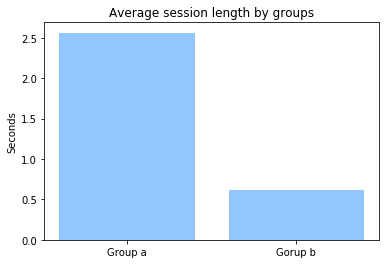

In [36]:
plt.bar(range(2),[2.561359,.612262])
plt.xticks(range(2),['Group a','Gorup b'])
plt.ylabel("Seconds")
plt.title('Average session length by groups')
plt.show()

## Train and Test a simple Classifier to predict if a user is likely to click on one of the search result that appears. Transform the data accordingly. (Bonus points for writing a classifier from scratch) Choose appropriate metrics to measure the performance of your algorithm and visualize the predictions if possible.


***Lets transfrom Data.***

In [32]:
target = clickthroughdata.groupby(['session_id'])['checkin'].count() > 0 #making the target value to whether uer clicked or not

In [37]:
clickthroughdata['clicked'] = clickthroughdata.session_id.apply(lambda x: target[x] )
df = clickthroughdata[clickthroughdata.action == 'searchResultPage']

In [38]:
#Dropping these columns as some of them are constant and some do not have relation to target
df.drop(['uuid','timestamp','session_id','action','page_id','result_position','day','month','checkin'],inplace=True,axis=1)
print(df.shape)
df.head()


(123582, 3)


,group,n_results,clicked
0,b,5.0,True
1,a,10.0,False
7,b,15.0,False
10,a,20.0,True
12,a,9.0,True


In [63]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [106]:
df.group.replace({'a':0,'b':1},inplace=True)

***Using LightGBM as it as an ensemble type classifier.***

In [107]:
score =  cross_val_score(LGBMClassifier(n_estimators=40,class_weight='balanced',num_leaves=15),df[['group','n_results']],df.clicked,scoring='roc_auc',cv=5)

In [108]:
print('Auc of 5 fold CV: ',score.mean())

Auc of 5 fold CV:  0.7133597710421875


In [109]:
predict = cross_val_predict(LGBMClassifier(n_estimators=40,class_weight='balanced',num_leaves=15),df[['group','n_results']],df.clicked,cv=5)

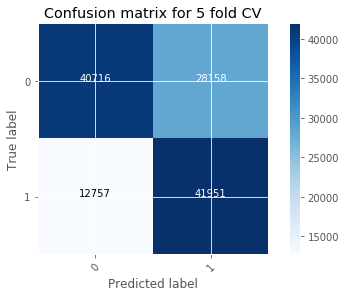

In [110]:
plot_confusion_matrix(metrics.confusion_matrix(df.clicked,predict),range(2),title="Confusion matrix for 5 fold CV")

In [111]:
print(metrics.classification_report(df.clicked,predict))


             precision    recall  f1-score   support

      False       0.76      0.59      0.67     68874
       True       0.60      0.77      0.67     54708

avg / total       0.69      0.67      0.67    123582



In [112]:
l = LGBMClassifier(n_estimators=40,class_weight='balanced',num_leaves=15).fit(df[['group','n_results']],df.clicked)

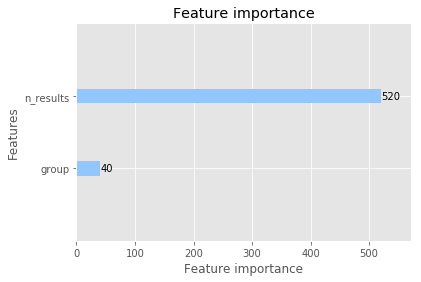

In [113]:
lgb.plot_importance(l)

In [114]:
graph = lgb.create_tree_digraph(l, tree_index=3, name='1') # saving the digram in pdf format
graph.render(view=True)


'1.gv.pdf'

Let's check

In [57]:
df[df.clicked == False]['n_results'].mean(),df[df.clicked == True]['n_results'].mean()

(13.716293521503035, 15.627878920815968)

## Summary

 1. Group A users tends to use website more than Group users B.
 2. Group A users have high clickthrough rate means website have topics that are useful to them.
 3. Zero result rate are nearly same for the both type of users.
 4. More number of results usually does not mean that user will click on result.
 5. 